In [1]:
# import data handling tools
import cv2
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import zipfile

from google.colab import drive, files
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
dir = '/content/gdrive/MyDrive/Colab Notebooks/Lab3/data'
filepaths = []
labels = []

folds = os.listdir(dir)
for fold in folds:
    foldpath = os.path.join(dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=1)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
valid_gen = train_datagen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)
test_gen = train_datagen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)
class_names = list(train_gen.class_indices.keys())

Found 245 validated image filenames belonging to 6 classes.
Found 62 validated image filenames belonging to 6 classes.
Found 77 validated image filenames belonging to 6 classes.


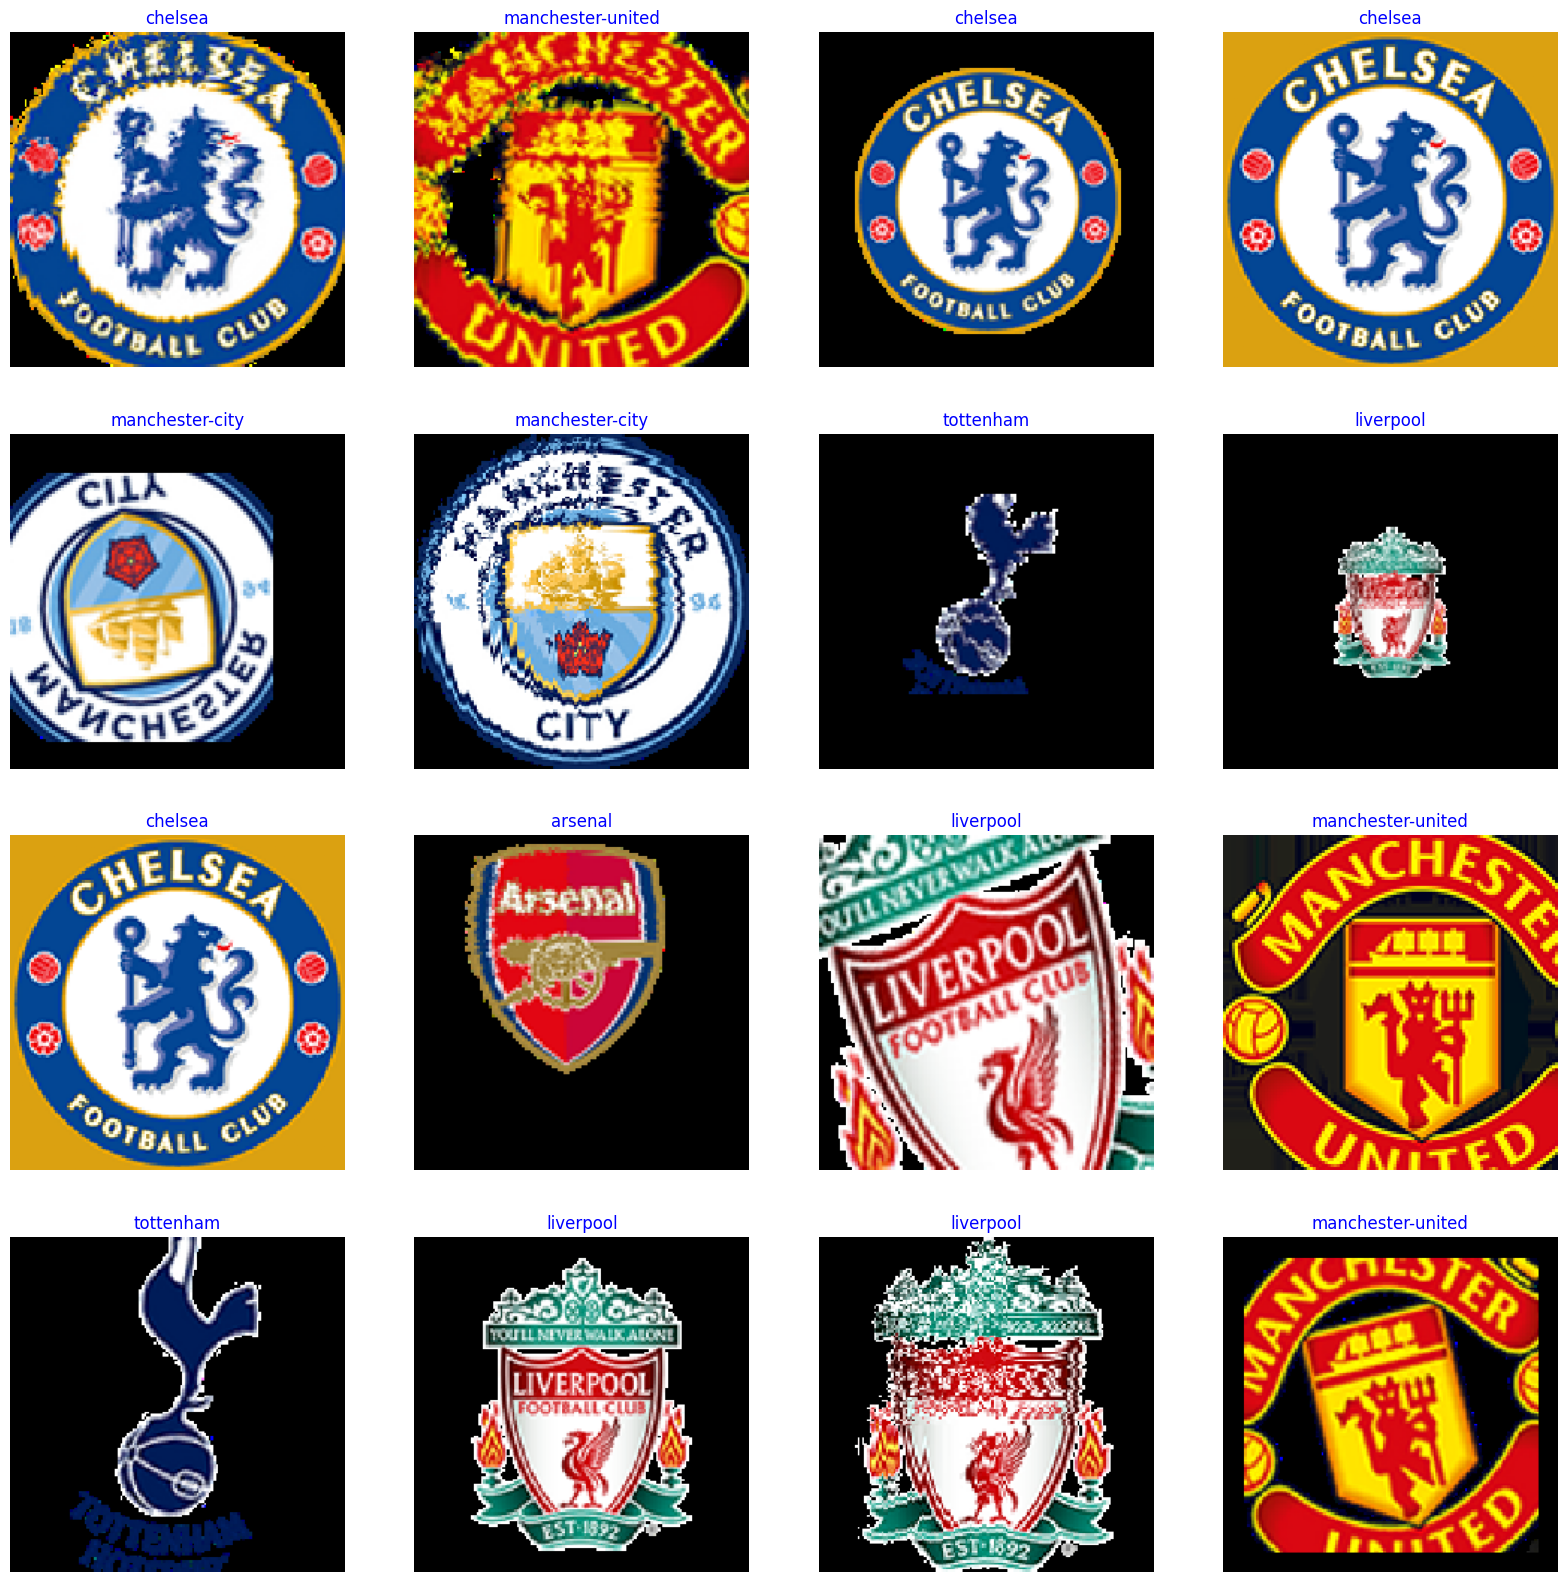

In [ ]:
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = class_names[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [9]:
# Определение архитектуры нейронной сети
model = Sequential()

# Сверточные слои
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model.add(MaxPooling2D((2, 2)))

# Преобразование трехмерных карт признаков в одномерный вектор
model.add(Flatten())

# Полносвязные слои
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Выходной слой
model.add(Dense(6, activation='softmax'))

# Компиляция модели
model.compile(Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод структуры модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 64)                25233472  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                        

In [10]:
# Обучение модели
history = model.fit(
    train_gen,
    epochs = 5,  # Количество эпох обучения
    validation_data = valid_gen
)

# Оценка точности на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/5
 4/16 [======>.......................] - ETA: 32s - loss: 14.5905 - accuracy: 0.2642

KeyboardInterrupt: 

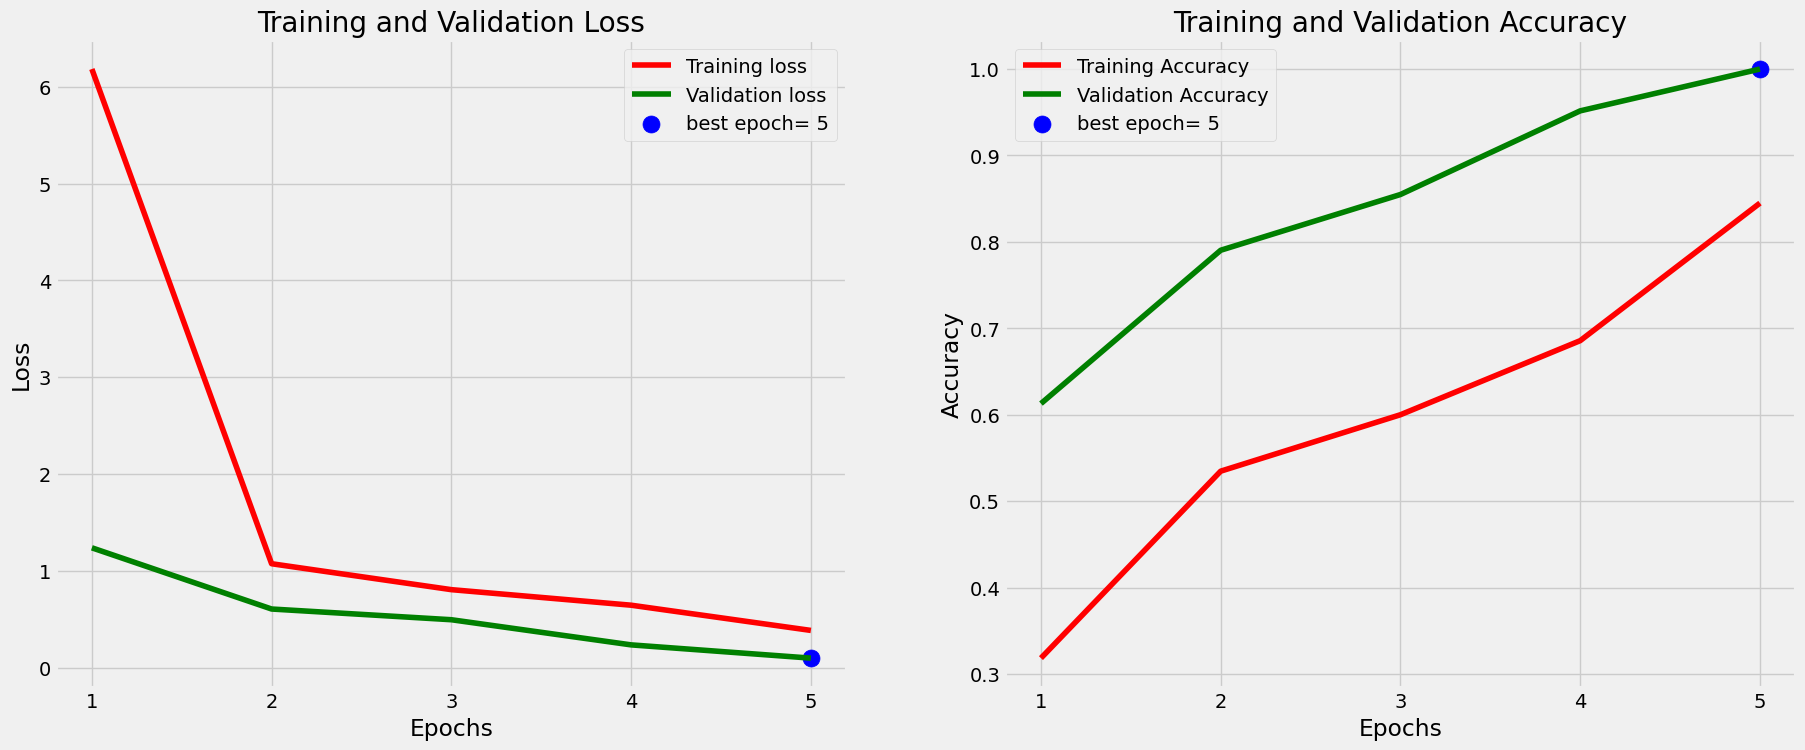

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xticks(Epochs)
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(Epochs)
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<ipython-input-22-01135dd8c8ed>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


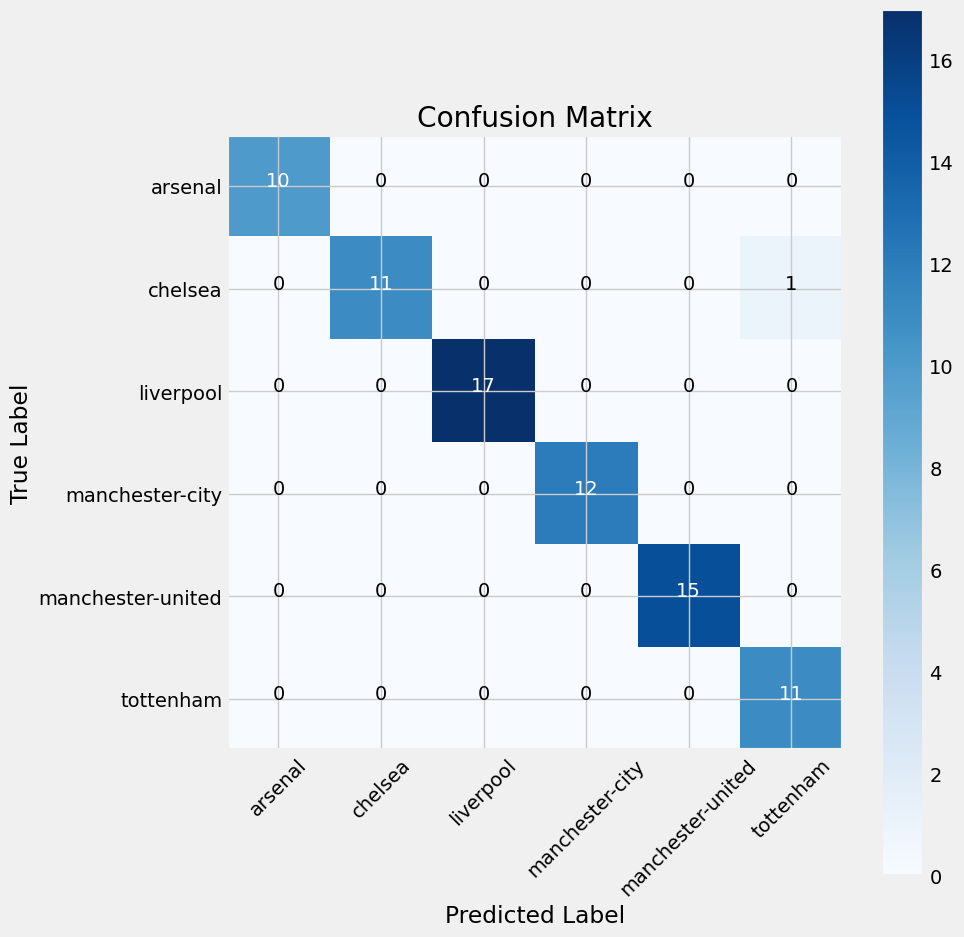

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/Lab3/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Lab3/model.h5', compile=False)
loaded_model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
demo_dir = '/content/gdrive/MyDrive/Lab3/data/arsenal'
filepaths = []
labels = []

filelist = os.listdir(demo_dir)
for file in filelist:
    fpath = os.path.join(demo_dir, file)
    filepaths.append(fpath)
    labels.append('chelsea')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
demo_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
demo_gen = train_datagen.flow_from_dataframe(demo_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

Found 64 validated image filenames belonging to 1 classes.


In [ ]:
demo_preds = model.predict(demo_gen)
demo_pred = np.argmax(demo_preds, axis=1)
demo_pred = [class_names[i] for i in demo_pred]
demo_pred

4/4 [==============================] - 1s 218ms/step


['arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal',
 'arsenal']